In [1]:
import warnings

import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder


%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn.datasets import make_moons
from sklearn.svm import SVC

from mlxtend.plotting import plot_decision_regions

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from scipy import stats



In [2]:
def eval_preds(y_true, y_pred): 
    error = y_true - y_pred
    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Gaukhar-ai/for_my_Thinkful_work/master/capstone/NY_real_estate/nyc-rolling-sales.csv')
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [5]:
df.shape

(84548, 22)

In [6]:
#dropping highly correlated and unnecessary columns:

drop_cols = ['TAX CLASS AT PRESENT', 'Unnamed: 0', 'NEIGHBORHOOD', 'BOROUGH', 'BLOCK', 'BUILDING CLASS AT PRESENT', 'LOT', 'EASE-MENT', 
            'APARTMENT NUMBER', 'TOTAL UNITS', 'ADDRESS']
df.drop(columns = drop_cols, inplace=True) 

In [7]:
df.head()

,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,07 RENTALS - WALKUP APARTMENTS,10009,5,0,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,07 RENTALS - WALKUP APARTMENTS,10009,28,3,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,07 RENTALS - WALKUP APARTMENTS,10009,16,1,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,07 RENTALS - WALKUP APARTMENTS,10009,10,0,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,07 RENTALS - WALKUP APARTMENTS,10009,6,0,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [8]:
#let's see how many rows have null values:

df.isnull().sum()

BUILDING CLASS CATEGORY           0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64

In [9]:
df.dtypes

BUILDING CLASS CATEGORY           object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

In [10]:
#see how many value counts i have in each column
col = df[0:]
for c in col:
    print("Value counts for " + c)
    print(df[c].value_counts())

Value counts for BUILDING CLASS CATEGORY
01 ONE FAMILY DWELLINGS                         18235
02 TWO FAMILY DWELLINGS                         15828
13 CONDOS - ELEVATOR APARTMENTS                 12989
10 COOPS - ELEVATOR APARTMENTS                  12902
03 THREE FAMILY DWELLINGS                        4384
07 RENTALS - WALKUP APARTMENTS                   3466
09 COOPS - WALKUP APARTMENTS                     2767
04 TAX CLASS 1 CONDOS                            1656
44 CONDO PARKING                                 1441
15 CONDOS - 2-10 UNIT RESIDENTIAL                1281
05 TAX CLASS 1 VACANT LAND                       1248
17 CONDO COOPS                                   1201
22 STORE BUILDINGS                                935
12 CONDOS - WALKUP APARTMENTS                     926
14 RENTALS - 4-10 UNIT                            671
29 COMMERCIAL GARAGES                             587
43 CONDO OFFICE BUILDINGS                         475
31 COMMERCIAL VACANT LAND                

In [12]:
#installing pgeocode to get the latitude and longitude to substitute the categorical column zip code to numeric and delete the
#address col. 
#first I tried to use the geopy for the address but it would've taken more than 72 hours to finish the process. So I took the 
#zip code, since it had only 300 cols instead of 80K rows. 

#!pip install pgeocode
import pgeocode

In [13]:
nomi = pgeocode.Nominatim('us') #taking zips for US only here

a = nomi.query_postal_code("10016")

In [14]:
nomi.query_postal_code(10016).longitude

-73.9781

In [15]:
#nomi = pgeocode.Nominatim('us')
nomi.query_postal_code(10016).latitude

40.7443

In [16]:
#stored all zip codes to unique_zip

unique_zip = df['ZIP CODE'].unique()
a = {'zip': unique_zip}
zip_df = pd.DataFrame(data=a) #can covert dictionaries to DF

In [17]:
#applying the function nomi.query_postal_code to zip and getting this incredible info about the address. All i need and more.
zip_ny=zip_df['zip'].apply(nomi.query_postal_code)

In [18]:
zip_ny

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,10009,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7262,-73.9796,4.0
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7152,-73.9877,4.0
3,10011,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7402,-73.9996,4.0
4,10001,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7484,-73.9967,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
181,10304,US,Staten Island,New York,NY,Richmond,85.0,NaN,NaN,40.6102,-74.0878,4.0
182,10306,US,Staten Island,New York,NY,Richmond,85.0,NaN,NaN,40.5682,-74.1184,4.0
183,10308,US,Staten Island,New York,NY,Richmond,85.0,NaN,NaN,40.5518,-74.1526,4.0
184,10309,US,Staten Island,New York,NY,Richmond,85.0,NaN,NaN,40.5352,-74.2116,4.0


In [19]:
zip_ny.head()

,postal_code,country code,place_name,state_name,state_code,county_name,county_code,community_name,community_code,latitude,longitude,accuracy
0,10009,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7262,-73.9796,4.0
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10002,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7152,-73.9877,4.0
3,10011,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7402,-73.9996,4.0
4,10001,US,New York,New York,NY,New York,61.0,NaN,NaN,40.7484,-73.9967,4.0


In [20]:
#zip_ny[['latitude,'longitude']]
#renamed the postal code to ZIP CODE, cuz i have the same column name in an original df

zip_ny=zip_ny.rename(columns={"postal_code": "ZIP CODE"})

In [21]:
#converting the zip code to numeric
zip_ny['ZIP CODE'] = pd.to_numeric(zip_ny['ZIP CODE'], errors='coerce')

In [22]:
zip_ny.info() #checking if zip is numeric here, and it is!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ZIP CODE        186 non-null    int64  
 1   country code    185 non-null    object 
 2   place_name      185 non-null    object 
 3   state_name      185 non-null    object 
 4   state_code      185 non-null    object 
 5   county_name     185 non-null    object 
 6   county_code     185 non-null    float64
 7   community_name  0 non-null      float64
 8   community_code  0 non-null      float64
 9   latitude        185 non-null    float64
 10  longitude       185 non-null    float64
 11  accuracy        185 non-null    float64
dtypes: float64(6), int64(1), object(5)
memory usage: 13.9+ KB


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BUILDING CLASS CATEGORY         84548 non-null  object
 1   ZIP CODE                        84548 non-null  int64 
 2   RESIDENTIAL UNITS               84548 non-null  int64 
 3   COMMERCIAL UNITS                84548 non-null  int64 
 4   LAND SQUARE FEET                84548 non-null  object
 5   GROSS SQUARE FEET               84548 non-null  object
 6   YEAR BUILT                      84548 non-null  int64 
 7   TAX CLASS AT TIME OF SALE       84548 non-null  int64 
 8   BUILDING CLASS AT TIME OF SALE  84548 non-null  object
 9   SALE PRICE                      84548 non-null  object
 10  SALE DATE                       84548 non-null  object
dtypes: int64(5), object(6)
memory usage: 5.2+ MB


In [24]:
#merging two data frames by zip code, adding to the newly created df_geo, lat and long
zip_ny.head()
df_geo=pd.merge(df, zip_ny[['ZIP CODE','latitude', 'longitude']], on ='ZIP CODE', how = 'left')

In [25]:
#df['ZIP CODE'] = result.apply(get_latitude)
#df['ZIP CODE'] = result.apply(get_longitude)
#df['ZIP CODE'], index = False)


In [26]:
df_geo.describe()

,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE,latitude,longitude
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,83566.000000,83566.000000
mean,10731.991614,2.025264,0.193559,1789.322976,1.657485,40.707847,-73.930330
std,1290.879147,16.721037,8.713183,537.344993,0.819341,0.078980,0.102694
min,0.000000,0.000000,0.000000,0.000000,1.000000,40.508500,-74.244500
25%,10305.000000,0.000000,0.000000,1920.000000,1.000000,40.646700,-73.985600
50%,11209.000000,1.000000,0.000000,1940.000000,2.000000,40.711900,-73.944700
75%,11357.000000,2.000000,0.000000,1965.000000,2.000000,40.761100,-73.858500
max,11694.000000,1844.000000,2261.000000,2017.000000,4.000000,40.904500,-73.682800


In [27]:
drop_cols = ['ZIP CODE']
df_geo.drop(columns = drop_cols, inplace=True) 
#dropped the zip code col, since i already have the lat and long

In [28]:
df_geo.head()

,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,latitude,longitude
0,07 RENTALS - WALKUP APARTMENTS,5,0,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00,40.7262,-73.9796
1,07 RENTALS - WALKUP APARTMENTS,28,3,4616,18690,1900,2,C7,-,2016-12-14 00:00:00,40.7262,-73.9796
2,07 RENTALS - WALKUP APARTMENTS,16,1,2212,7803,1900,2,C7,-,2016-12-09 00:00:00,40.7262,-73.9796
3,07 RENTALS - WALKUP APARTMENTS,10,0,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00,40.7262,-73.9796
4,07 RENTALS - WALKUP APARTMENTS,6,0,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00,40.7262,-73.9796


In [29]:
#sale price was an object in df, because it had '-', which i decided to drop, since I have a large dataset. 

df_geo['SALE PRICE'].value_counts()

 -         14561
0          10228
10           766
450000       427
550000       416
           ...  
338914         1
356803         1
749631         1
1057000        1
506983         1
Name: SALE PRICE, Length: 10008, dtype: int64

In [30]:
#converting all cat cols to numeric.

df_geo['LAND SQUARE FEET'] = pd.to_numeric(df_geo['LAND SQUARE FEET'], errors='coerce')
df_geo['GROSS SQUARE FEET']= pd.to_numeric(df_geo['GROSS SQUARE FEET'], errors='coerce')
df_geo['SALE PRICE'] = pd.to_numeric(df_geo['SALE PRICE'], errors='coerce')


In [31]:
#filtering on price, because saw that some sale prices are $0 to $10, probably inherited by parents, or sold to kids.
#these are whole buildings with units inside, so min filter i chose $100K

df_geo = df_geo[(df_geo['SALE PRICE'] >= 100000) & (df_geo['SALE PRICE'] <= 1.25e8)] #125000000
df_geo = df_geo[(df_geo['GROSS SQUARE FEET'] >= 100)]

In [32]:
df_sale=df_geo.dropna(subset = ['SALE PRICE'], inplace = True)
df_geo.head() #to drop rows with nas from the column sale price


,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,latitude,longitude
0,07 RENTALS - WALKUP APARTMENTS,5,0,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00,40.7262,-73.9796
3,07 RENTALS - WALKUP APARTMENTS,10,0,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00,40.7262,-73.9796
4,07 RENTALS - WALKUP APARTMENTS,6,0,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00,40.7262,-73.9796
6,07 RENTALS - WALKUP APARTMENTS,8,0,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23 00:00:00,40.7262,-73.9796
9,08 RENTALS - ELEVATOR APARTMENTS,24,0,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07 00:00:00,40.7262,-73.9796


In [33]:
df_geo['SALE PRICE'].describe()

count    2.793100e+04
mean     1.391270e+06
std      4.632838e+06
min      1.000000e+05
25%      4.461095e+05
50%      6.400000e+05
75%      9.750000e+05
max      1.250000e+08
Name: SALE PRICE, dtype: float64

In [34]:
num_cols = ['GROSS SQUARE FEET', 'LAND SQUARE FEET', 'YEAR BUILT','latitude', 'longitude']

bin_cols = []

cat_cols =  ['BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'BUILDING CLASS AT TIME OF SALE']
drop_cats = []


In [35]:
#filling NAs with the mean in land and gross square feet.

df_geo['LAND SQUARE FEET']=df_geo['LAND SQUARE FEET'].fillna(df_geo['LAND SQUARE FEET'].mean())
df_geo['GROSS SQUARE FEET']=df_geo['GROSS SQUARE FEET'].fillna(df_geo['GROSS SQUARE FEET'].mean())

<AxesSubplot:>

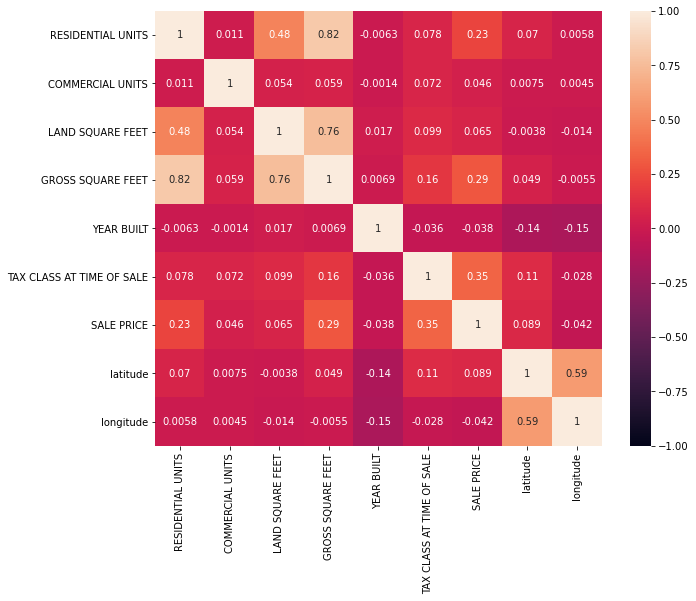

In [36]:
plt.figure(figsize=(10, 8))
corr = df_geo.corr()
sns.heatmap(corr, vmin = -1, annot = True)

In [37]:
#the highest corr is the gross square feet, which makes sense. I was surprised to see the year built to have a negative corr
#since i thought older is cheaper, or vise versa sometimes, when it's considered a heritage.

corr_sale = corr['SALE PRICE'].sort_values(ascending=False)
corr_sale
#looking at the price and its correlation to other numeric data

SALE PRICE                   1.000000
TAX CLASS AT TIME OF SALE    0.348604
GROSS SQUARE FEET            0.289526
RESIDENTIAL UNITS            0.225293
latitude                     0.089128
LAND SQUARE FEET             0.064894
COMMERCIAL UNITS             0.045897
YEAR BUILT                  -0.038048
longitude                   -0.041664
Name: SALE PRICE, dtype: float64

In [38]:
df_geo['SALE PRICE'].value_counts()

700000.0    290
450000.0    283
600000.0    282
650000.0    279
550000.0    276
           ... 
641709.0      1
608940.0      1
739999.0      1
242343.0      1
393219.0      1
Name: SALE PRICE, Length: 4511, dtype: int64

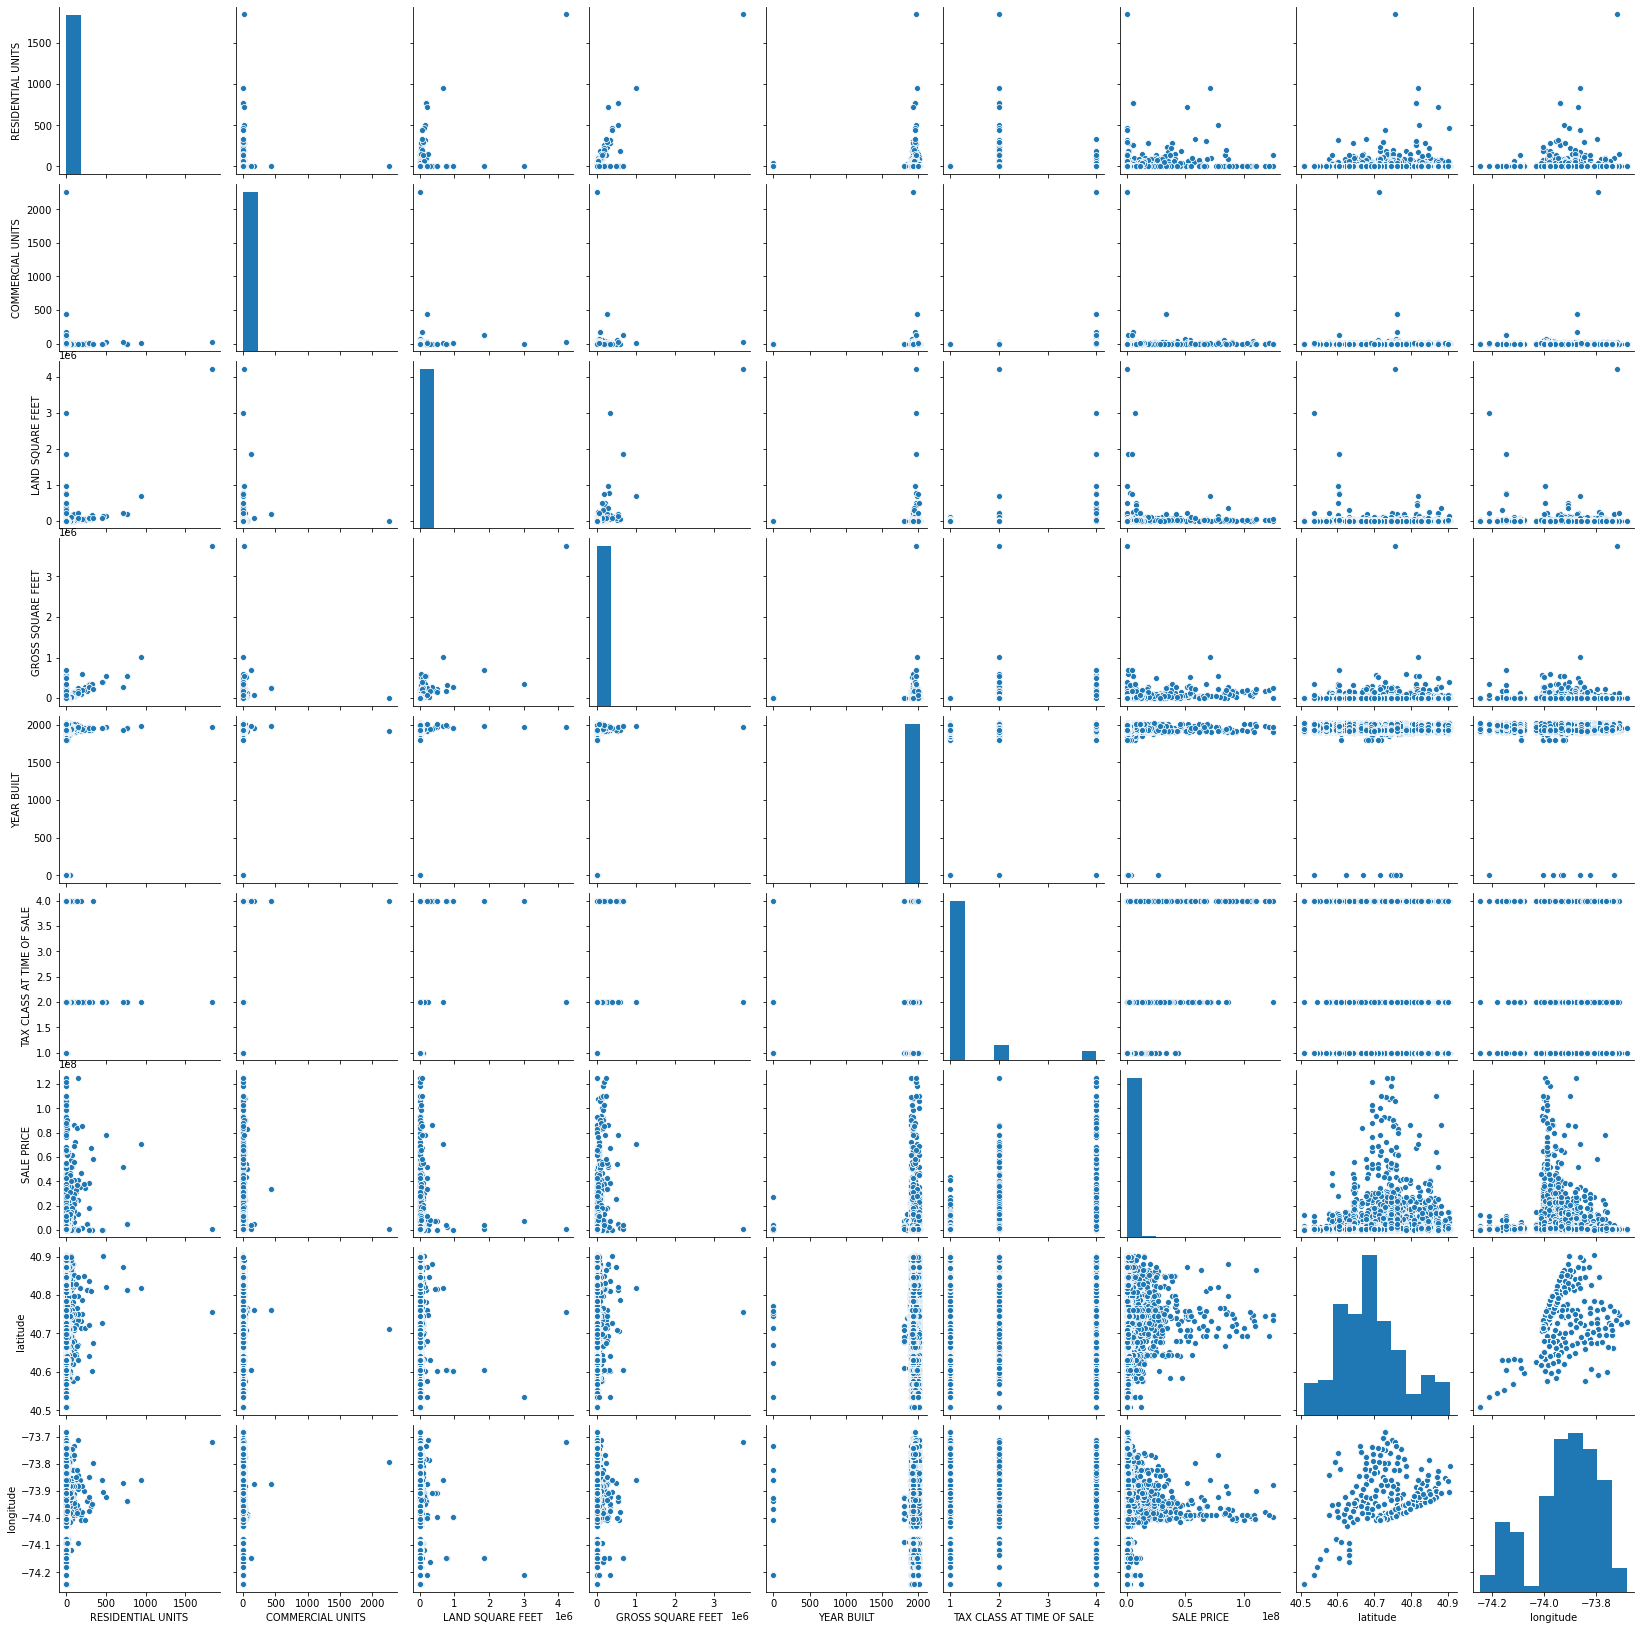

In [39]:
#looking at the pairplot I see the right skew and the data is not normal, so I'll use the log transform.
#sns.pairplot(df_geo)


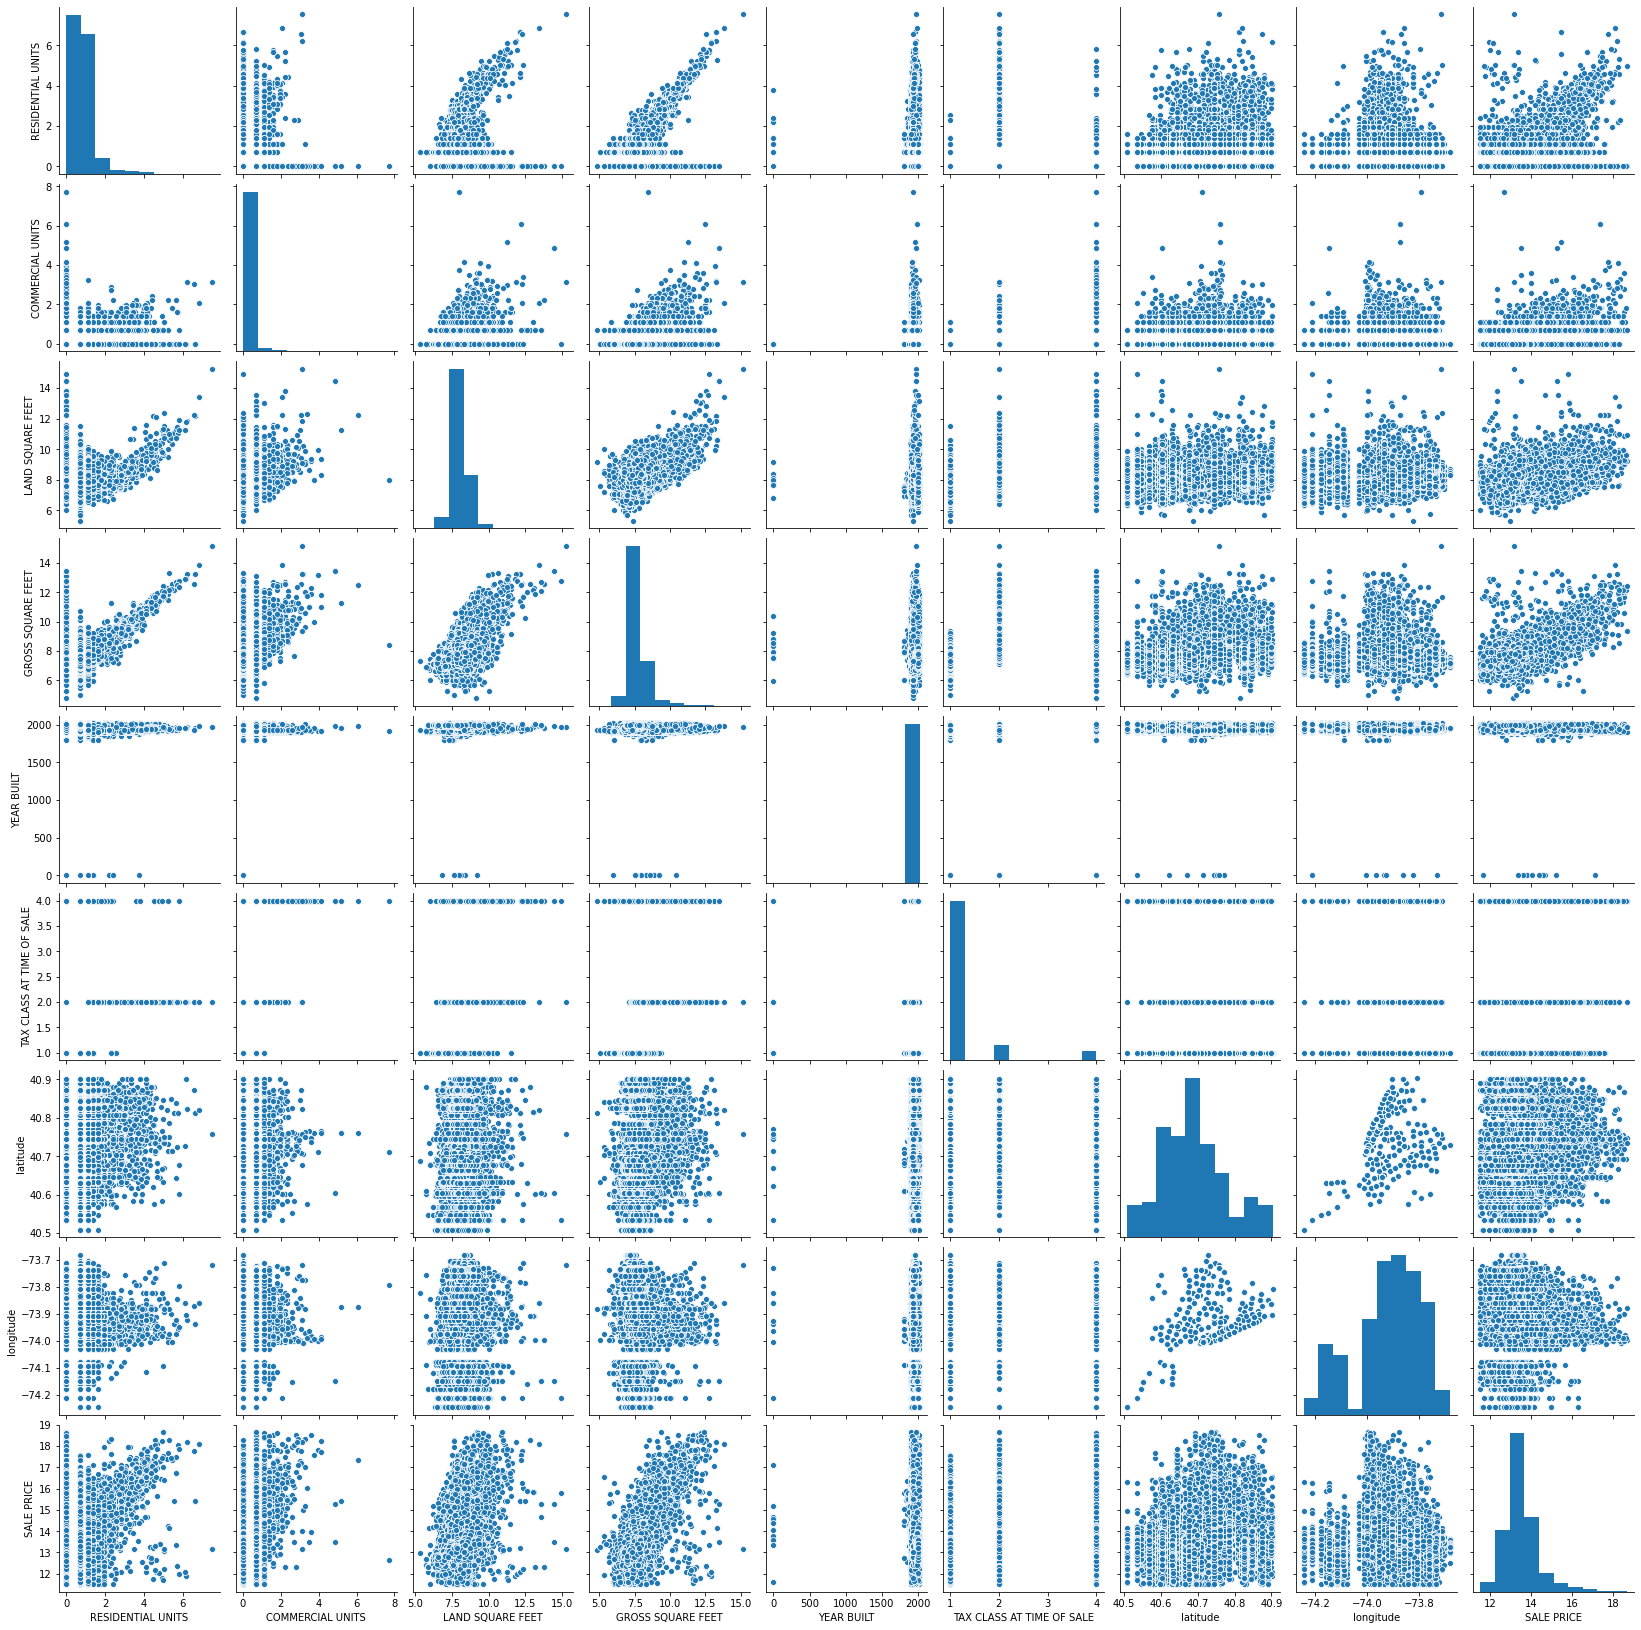

In [40]:
#now i see the trend and gross square feet with a sale price are well correlated.
df_geo_log = df_geo.copy()
df_geo_log['SALE PRICE'] = np.log(df_geo_log['SALE PRICE']+1)
df_geo_log['GROSS SQUARE FEET'] = np.log(df_geo_log['GROSS SQUARE FEET']+1)
df_geo_log['RESIDENTIAL UNITS'] = np.log(df_geo_log['RESIDENTIAL UNITS']+1)   #+1 so it won't be 0
df_geo_log['COMMERCIAL UNITS'] = np.log(df_geo_log['COMMERCIAL UNITS']+1)
df_geo_log['LAND SQUARE FEET'] = np.log(df_geo_log['LAND SQUARE FEET']+1)
sns.pairplot(df_geo_log[['BUILDING CLASS CATEGORY', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'latitude', 'longitude', 'SALE PRICE']])

In [41]:
df_geo_log.columns

Index(['BUILDING CLASS CATEGORY', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'latitude', 'longitude'],
      dtype='object')

In [42]:
df_geo[["COMMERCIAL UNITS", "SALE PRICE"]].groupby(['COMMERCIAL UNITS']).count().sort_values(by='SALE PRICE', ascending=False)

#i have 1840 buildings with one commercial unit.
#54500 with 0 commercial units.

,SALE PRICE
COMMERCIAL UNITS,
0,25401
1,1764
2,388
3,127
4,77
5,45
6,35
8,18
7,11


In [43]:
df_geo[["RESIDENTIAL UNITS", "SALE PRICE"]].groupby(['RESIDENTIAL UNITS'], 
                                            as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

#17593 only commercial
#25230 units with one residential unit or single property = check it 

,RESIDENTIAL UNITS,SALE PRICE
1,1,12558
2,2,9711
3,3,2357
0,0,1155
4,4,671
...,...,...
96,121,1
97,122,1
98,129,1
99,134,1


In [44]:
#converting the time to a number, also i dont need what time what the purchase made. Taking a year and a month. 

df_geo_log['SALE DATE'] = pd.to_datetime(df_geo_log['SALE DATE'])
df_geo_log['year'] = df_geo_log['SALE DATE'].dt.year
df_geo_log['month'] = df_geo_log['SALE DATE'].dt.month
df_geo_log.head()

,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,latitude,longitude,year,month
0,07 RENTALS - WALKUP APARTMENTS,1.791759,0.0,7.398786,8.770439,1900,2,C2,15.706361,2017-07-19,40.7262,-73.9796,2017,7
3,07 RENTALS - WALKUP APARTMENTS,2.397895,0.0,7.728856,8.823942,1913,2,C4,15.185745,2016-09-23,40.7262,-73.9796,2016,9
4,07 RENTALS - WALKUP APARTMENTS,1.945910,0.0,7.770645,8.437284,1900,2,C2,15.894952,2016-11-17,40.7262,-73.9796,2016,11
6,07 RENTALS - WALKUP APARTMENTS,2.197225,0.0,7.467942,8.349248,1920,2,C4,14.976422,2016-09-23,40.7262,-73.9796,2016,9
9,08 RENTALS - ELEVATOR APARTMENTS,3.218876,0.0,8.409608,9.826822,1920,2,D9,16.602495,2016-11-07,40.7262,-73.9796,2016,11


In [45]:
#dropping the sale date, since i got the month and a year.

df_geo_log = df_geo_log.drop(columns=["SALE DATE"])

df_geo_log.head()

,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,latitude,longitude,year,month
0,07 RENTALS - WALKUP APARTMENTS,1.791759,0.0,7.398786,8.770439,1900,2,C2,15.706361,40.7262,-73.9796,2017,7
3,07 RENTALS - WALKUP APARTMENTS,2.397895,0.0,7.728856,8.823942,1913,2,C4,15.185745,40.7262,-73.9796,2016,9
4,07 RENTALS - WALKUP APARTMENTS,1.945910,0.0,7.770645,8.437284,1900,2,C2,15.894952,40.7262,-73.9796,2016,11
6,07 RENTALS - WALKUP APARTMENTS,2.197225,0.0,7.467942,8.349248,1920,2,C4,14.976422,40.7262,-73.9796,2016,9
9,08 RENTALS - ELEVATOR APARTMENTS,3.218876,0.0,8.409608,9.826822,1920,2,D9,16.602495,40.7262,-73.9796,2016,11


In [46]:
df_geo['SALE PRICE'] = pd.to_numeric(df_geo['SALE PRICE'], errors='coerce')

In [47]:
df_geo.dropna(subset = ['SALE PRICE'], inplace = True)
df_geo.head() #to drop rows with nas from the column sale price


,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,latitude,longitude
0,07 RENTALS - WALKUP APARTMENTS,5,0,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19 00:00:00,40.7262,-73.9796
3,07 RENTALS - WALKUP APARTMENTS,10,0,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23 00:00:00,40.7262,-73.9796
4,07 RENTALS - WALKUP APARTMENTS,6,0,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17 00:00:00,40.7262,-73.9796
6,07 RENTALS - WALKUP APARTMENTS,8,0,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23 00:00:00,40.7262,-73.9796
9,08 RENTALS - ELEVATOR APARTMENTS,24,0,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07 00:00:00,40.7262,-73.9796


In [48]:
df_geo_log.head()

,BUILDING CLASS CATEGORY,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,latitude,longitude,year,month
0,07 RENTALS - WALKUP APARTMENTS,1.791759,0.0,7.398786,8.770439,1900,2,C2,15.706361,40.7262,-73.9796,2017,7
3,07 RENTALS - WALKUP APARTMENTS,2.397895,0.0,7.728856,8.823942,1913,2,C4,15.185745,40.7262,-73.9796,2016,9
4,07 RENTALS - WALKUP APARTMENTS,1.945910,0.0,7.770645,8.437284,1900,2,C2,15.894952,40.7262,-73.9796,2016,11
6,07 RENTALS - WALKUP APARTMENTS,2.197225,0.0,7.467942,8.349248,1920,2,C4,14.976422,40.7262,-73.9796,2016,9
9,08 RENTALS - ELEVATOR APARTMENTS,3.218876,0.0,8.409608,9.826822,1920,2,D9,16.602495,40.7262,-73.9796,2016,11


In [49]:
#building class cat has rows with 1 or 2 unique categories, so i'm putting the threshold here of 10, and getting rid of 
#those unique 1 or 2 rows.
def keep_counts_above(series, thresh=10):
    counts = series.value_counts()
    keep_counts = counts[counts > thresh]
    keep_names = list(keep_counts.index)
    return keep_names

keep_buildings = keep_counts_above(df_geo_log['BUILDING CLASS CATEGORY'], 5)
df_geo_log = df_geo_log[df_geo_log['BUILDING CLASS CATEGORY'].isin(keep_buildings)]

In [50]:
keep_buildings = keep_counts_above(df_geo_log['BUILDING CLASS AT TIME OF SALE'], 5)
df_geo_log = df_geo_log[df_geo_log['BUILDING CLASS AT TIME OF SALE'].isin(keep_buildings)]

In [51]:
#let's start to model:

df_geo_log = df_geo_log.dropna()
y = df_geo_log['SALE PRICE']
X = df_geo_log.drop('SALE PRICE', axis=1)

In [52]:
X_train ,X_test, y_train , y_test = train_test_split(X , y, test_size = 0.2 , random_state =55)

In [53]:
df_geo_log['BUILDING CLASS CATEGORY'].value_counts().head().index
#taking it like this, because it gave errors, so i had to include spacing too, just like below.

Index(['01 ONE FAMILY DWELLINGS                    ',
       '02 TWO FAMILY DWELLINGS                    ',
       '03 THREE FAMILY DWELLINGS                  ',
       '07 RENTALS - WALKUP APARTMENTS             ',
       '22 STORE BUILDINGS                         '],
      dtype='object')

In [54]:
# # Let's see the Linear Regression model. 
# num_cols = ['RESIDENTIAL UNITS',"COMMERCIAL UNITS",'LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','latitude', 'longitude', 'year', 'month']

# bin_cols = []

# cat_cols = ['BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE']
# drop_cats = ['01 ONE FAMILY DWELLINGS                    ', 2, 'D4' ]

# preprocessing = ColumnTransformer([
#     # Should only use one of these
#     # Comment out or delete one of the below 2 lines
#     ('OneHotEncoder', OneHotEncoder(drop=drop_cats), cat_cols),    
#     #('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),

#     # Scale numeric columns (not needed for all models but can't hurt)
#     ('scaler', StandardScaler(), num_cols)
    
#     # bin_cols we'll leave untouch
# ], remainder='passthrough')

# pipeline = Pipeline([
#     ('preprocessing', preprocessing),
#     # Choose your model and put it here
#     ('model', LinearRegression())
# ])


# pipeline.fit(X_train, y_train)

# print(pipeline.score(X_train, y_train))
# print(pipeline.score(X_test, y_test))


# # grid = {
# #     # Use model__ with hyperprammeter names after
# #     #'model__n_estimators':[100, 150]    
# # }

# # pipeline_cv = GridSearchCV(pipeline, grid)
# # pipeline_cv.fit(X_train, y_train)

# # print(pipeline_cv.score(X_train, y_train))
# # print(pipeline_cv.score(X_test, y_test))


# #underfit, very low accuracy, but it's better than nothing, right? so moving on to next though..

In [56]:
# y_pred = pipeline.predict(X_test) #
# eval_preds(np.exp(y_test), np.exp(y_pred))

In [ ]:
# y_pred = pipeline.predict(X_test) #
# eval_preds(y_test, y_pred)

In [ ]:
#Support Vector Regression

from sklearn.svm import SVR
# Fill out your column datatypes here
num_cols = ['RESIDENTIAL UNITS',"COMMERCIAL UNITS",'LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','latitude', 'longitude', 'year', 'month']

bin_cols = []

cat_cols = ['BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE']
drop_cats = ['01 ONE FAMILY DWELLINGS                    ', 2, 'D4' ]

preprocessing = ColumnTransformer([
    # Should only use one of these
    # Comment out or delete one of the below 2 lines
    #('OneHotEncoder', OneHotEncoder(drop=drop_cats), cat_cols),    
    ('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),

    # Scale numeric columns (not needed for all models but can't hurt)
    ('scaler', StandardScaler(), num_cols)
    
    # bin_cols we'll leave untouch
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    # Choose your model and put it here
    ('model', SVR())
])


pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))

#grid = {
    
    # Use model__ with hyperprammeter names after
    #'model__n_estimators':[100, 150]    
#}

#pipeline_cv = GridSearchCV(pipeline, grid)
#pipeline_cv.fit(X_train, y_train)

#print(pipeline_cv.score(X_train, y_train))
#print(pipeline_cv.score(X_test, y_test))

#much better than the previous one, little overfit. 

In [ ]:
y_pred = pipeline.predict(X_test) #
eval_preds(np.exp(y_pred),np.exp(y_test))
#On average the model's predictions are $850,000 from the right answer
#200,000,000

In [ ]:
#SVR not a good fit for the particular data points. 

In [61]:
#Random Forest Regressor, takes longer than others, I understand though, the data I have very large and I added the max depth to
#it = 9, so far the best accuracy on 9 than others. 


num_cols = ['RESIDENTIAL UNITS',"COMMERCIAL UNITS",'LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','latitude', 'longitude', 'year', 'month']

bin_cols = []

cat_cols = ['BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE']
drop_cats = ['01 ONE FAMILY DWELLINGS                    ', 2, 'D4' ]

preprocessing = ColumnTransformer([
    # Should only use one of these
    # Comment out or delete one of the below 2 lines
    #('OneHotEncoder', OneHotEncoder(drop=drop_cats), cat_cols),    
     ('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),

    # Scale numeric columns (not needed for all models but can't hurt)
    ('scaler', StandardScaler(), num_cols)
    
    # bin_cols we'll leave untouch
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    # Choose your model and put it here
    ('model',  RandomForestRegressor(max_depth=8.5))
])

pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))


#8.5 = 67, 70
#61, 63 = 7
                #73,69 = 10
#67, 70 = 9

#grid = {
    
#}
    # Use model__ with hyperprammeter names after
    #'model__n_estimators':[100, 150]    


#pipeline_cv = GridSearchCV(pipeline, grid)
#pipeline_cv.fit(X_train, y_train)

#print(pipeline_cv.score(X_train, y_train))
#print(pipeline_cv.score(X_test, y_test))


0.5466790746977321
0.5146029470890535


In [62]:
pipeline['model'].feature_importances_
#calling for feature importance on called 'model' for RF

array([3.63642239e-01, 1.43602133e-03, 4.30828306e-02, 5.47166443e-03,
       9.90351002e-04, 9.39500041e-03, 4.86032164e-01, 2.65028051e-03,
       2.53883532e-02, 6.07235805e-02, 4.61518301e-05, 1.14136320e-03])

rmse 3045779.76
mae 663520.70
mape 0.67


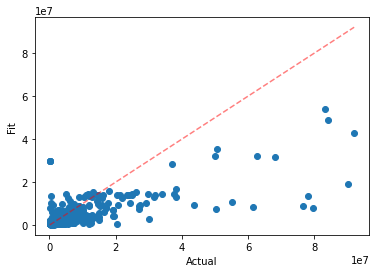

In [63]:
y_pred = pipeline.predict(X_test) #
eval_preds(np.exp(y_test), np.exp(y_pred))
#predicts well under 500K on 
#underpredicting weak points for big buyers. 

In [82]:
#DecisionTreeRegressor, this model performed better than the others, I used additional features to it to enhance it, since
#saw better performance. Added max_depth=9, min_samples_leaf = 55, max_leaf_nodes=150, min_samples_split=550. Experimented 
#with the numbers, going lower, higher, ended up with these numbers, since they presented a better output.

num_cols = ['RESIDENTIAL UNITS',"COMMERCIAL UNITS",'LAND SQUARE FEET','GROSS SQUARE FEET','YEAR BUILT','latitude', 'longitude', 'year', 'month']

bin_cols = []

cat_cols = ['BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE']
drop_cats = ['01 ONE FAMILY DWELLINGS                    ', 2, 'D4' ]

preprocessing = ColumnTransformer([
    # Should only use one of these
    # Comment out or delete one of the below 2 lines
    ('OneHotEncoder', OneHotEncoder(drop=drop_cats), cat_cols),    
    #('leaveoneoutencoder', LeaveOneOutEncoder(), cat_cols),

    # Scale numeric columns (not needed for all models but can't hurt)
    ('scaler', StandardScaler(), num_cols)
    
    # bin_cols we'll leave untouch
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    # Choose your model and put it here
    ('model',  DecisionTreeRegressor(max_depth=9, min_samples_leaf = 55, max_leaf_nodes=150,
                                    min_samples_split=550))
])


pipeline.fit(X_train, y_train)

print(pipeline.score(X_train, y_train))
print(pipeline.score(X_test, y_test))


#MAE = np.mean(np.abs(y_pred-y_test)) #calculating the mean absolute error. On average our predictions were within MAE of correct
#sale price. 

#grid = {
    # Use model__ with hyperprammeter names after
    #'model__n_estimators':[100, 150]    
#}

# pipeline_cv = GridSearchCV(pipeline, grid)
# pipeline_cv.fit(X_train, y_train)

# print(pipeline_cv.score(X_train, y_train))
# print(pipeline_cv.score(X_test, y_test))


0.6639697580586554
0.6458095805254964


All models are bit overfit. By accuracy the best performer so far is the Decision Tree. This was very interesting to do, and eye opening to certain things. 

In [80]:
from sklearn.tree import plot_tree

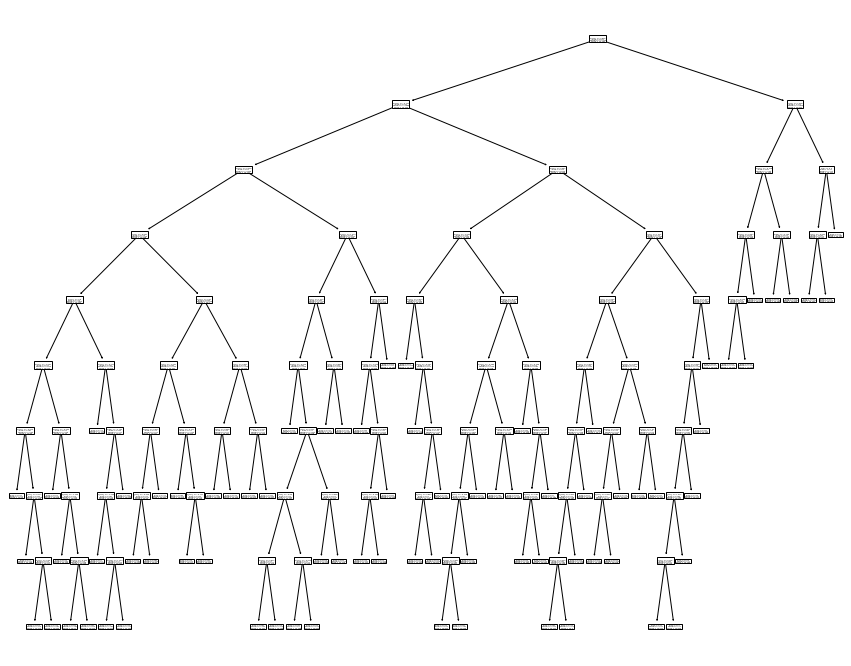

In [74]:
plt.figure(figsize=(15, 12))
plot_tree(pipeline['model'])
plt.show()

In [65]:
y_pred = pipeline.predict(X_test) #


rmse 3699791.78
mae 651172.15
mape 0.45


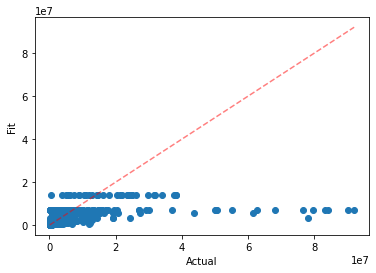

In [68]:
y_pred = pipeline.predict(X_test) #
eval_preds(np.exp(y_test), np.exp(y_pred))

In [81]:
importance_df = pd.DataFrame({'feat': X_train.columns, 'importance': pipeline['model'].feature_importances_})
importance_df.sort_values('importance', ascending=False)


,feat,importance
6,TAX CLASS AT TIME OF SALE,0.539767
0,BUILDING CLASS CATEGORY,0.381300
2,COMMERCIAL UNITS,0.037202
9,longitude,0.022937
8,latitude,0.018794
1,RESIDENTIAL UNITS,0.000000
3,LAND SQUARE FEET,0.000000
4,GROSS SQUARE FEET,0.000000
5,YEAR BUILT,0.000000
7,BUILDING CLASS AT TIME OF SALE,0.000000


rmse 0.50
mae 0.33
mape 0.02


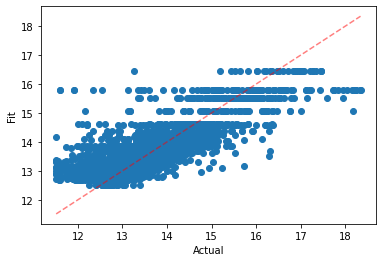

In [66]:
eval_preds(y_test, y_pred)

In [ ]:
# #np.log10(100)
# 10**2

In [ ]:
# np.log10(1000)
# 10**3

In [ ]:
# np.exp(np.log(1000))


In [ ]:
# e**np.log(1000)

This model building framework could be adjusted to build models for different markets


Reza Roshani Tabrizi1:09 PM
rmse: root mean score error

geometrical average of the error

act = 10, 12

pred = 11, 16

rmse =( (10-11)^2 + (12-16)^2 )^ (-1/2)

(1+16)^(-1)

17

4.xx

rmse/n

decision tree, random forest, knn, ...
linear regression

regulariaztion

reduce data size

10000

10,000
Multiple Models
Grid Search
Impact, standardizing
SVM

A ... Z
6 4